### Train model on Laws dataset for identifying attributions of NN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time #check min_threshold values for cloud storage
from sklearn.model_selection import train_test_split #don't use for time-series baseline!
from sklearn.metrics import accuracy_score, confusion_matrix

from tqdm import tqdm

import seed
from model import *

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
df = pd.read_csv("../data/laws/lawdf.csv")

In [3]:
df.head()

,Cluster__0,Cluster__1,Cluster__2,Cluster__3,Cluster__4,Cluster__5,Cluster__6,Cluster__7,Cluster__8,Cluster__9,...,onlineClassUsers,financeUsers,eCommerceUsers,sellingGoodsUsers,population,state_funds,fed_funds,total_spent,per_capita,cluster
0,0,1,0,0,0,0,0,0,0,0,...,-1.0,-1.0,-1.0,-1.0,4903185,15524,9911,25435,5218,1
1,0,0,0,0,0,0,0,1,0,0,...,-1.0,-1.0,-1.0,-1.0,4903185,15524,9911,25435,5218,7
2,0,1,0,0,0,0,0,0,0,0,...,-1.0,-1.0,-1.0,-1.0,4903185,15524,9911,25435,5218,1
3,0,0,0,0,1,0,0,0,0,0,...,-1.0,-1.0,-1.0,-1.0,4903185,15524,9911,25435,5218,4
4,0,0,0,0,0,1,0,0,0,0,...,-1.0,-1.0,-1.0,-1.0,4903185,15524,9911,25435,5218,5


## Data pre-processing

In [4]:
X_df = pd.concat([df.iloc[:, :10], df.iloc[:, -6:-1]], axis=1, join='inner').astype(float)
X_df.head()

,Cluster__0,Cluster__1,Cluster__2,Cluster__3,Cluster__4,Cluster__5,Cluster__6,Cluster__7,Cluster__8,Cluster__9,population,state_funds,fed_funds,total_spent,per_capita
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4903185.0,15524.0,9911.0,25435.0,5218.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4903185.0,15524.0,9911.0,25435.0,5218.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4903185.0,15524.0,9911.0,25435.0,5218.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4903185.0,15524.0,9911.0,25435.0,5218.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4903185.0,15524.0,9911.0,25435.0,5218.0


In [5]:
y_df = df.iloc[:, 15: -6].astype(float)
y_df.head()

,desktop_use,laptop_use,tablet_use,mobile_use,smartTV_use,wearable_use,intUsers_above3,intUsers_above15,homeIntUsers,workIntUsers,...,socialNetUsers,publishUsers,onlineConfUsers,videoUsers,teleworkUsers,jobSearchUsers,onlineClassUsers,financeUsers,eCommerceUsers,sellingGoodsUsers
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [6]:
#split into training and testing
X = X_df.values
y = y_df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train = (X_train - X_train.min())/X_train.max()
X_test = (X_test - X_test.min())/X_test.max()
y_train = (y_train - y_train.min())/y_train.max()
y_test = (y_test - y_test.min())/y_test.max()

In [8]:
X_train.max()

1.0

In [9]:
print(f"Training data feature space: {X_train.shape}")
print(f"Testing data feature space: {X_test.shape}")

Training data feature space: (586, 15)
Testing data feature space: (147, 15)


In [10]:
### Create tensors from np.ndarry main data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Enable cuda if available

X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.FloatTensor(y_train).to(device)
y_test = torch.FloatTensor(y_test).to(device)

In [11]:
# torch.save([X_train, y_train], '../data/loans/tensor_train.pt')
# torch.save([X_test, y_test],   '../data/loans/tensor_test.pt')

In [12]:
# X_train, X_test, y_train, y_test = seed.gather_laws()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Enable cuda if available

# seed the model for reproducibility (ideally across all nodes, later...)
torch.manual_seed(0)

dimensions = X_train.shape[1], y_train.shape[1]
model = LawsNetwork(*dimensions).to(device)

# implement backprop
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)

In [13]:
def train(epochs=int(1e3), epsilon=0):
    """
    Train the model. Assumes access to global variables X_train, X_test, y_train, y_test, loss function & optim.
    """
    start_time = time.time()
    losses = []
    
    for i in tqdm(range(epochs)):
        y_pred = model(X_train)
        loss = loss_function(y_pred, y_train)
        losses.append(loss)
        
        if loss.item() < epsilon:
            print(f"Model Converged at epoch {i + 1}, loss = {loss.item()}")
            break
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Total training time (sec): {time.time() - start_time}, loss - {loss.item()}")
    
    return losses

def save_model(PATH):
    torch.save(model.state_dict(), "../model/" + PATH)

In [14]:
cost = train()

100%|██████████| 1000/1000 [00:01<00:00, 820.53it/s]

Total training time (sec): 1.2228078842163086, loss - 0.0007495657191611826


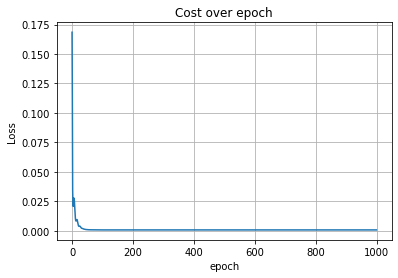

In [15]:
#graph cost
plt.plot(cost)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Cost over epoch")
plt.grid()
plt.show()

save_model("laws.pth")

## Evaluate Training Set

In [16]:
# model = LoanNetwork(*dimensions).to(device)
# load_model(PATH="loans_model.pth")
model.eval() #set to evaluation mode

#### predict X_test data
predictions=[]
with torch.no_grad():
    for i, data in enumerate(X_train):
        y_pred = model(data)
        predictions.append(y_pred.numpy())
predictions = np.array(predictions)

In [17]:
loss_function(torch.tensor(predictions), y_train)

tensor(0.0007)

### Evaluate Test Set

In [18]:
# model = LoanNetwork(*dimensions).to(device)
# load_model(PATH="loans_model.pth")
model.eval() #set to evaluation mode

#### predict X_test data
predictions=[]
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_pred = model(data)
        predictions.append(y_pred.numpy())
predictions = np.array(predictions)

In [19]:
loss_function(torch.tensor(predictions), y_test)

tensor(0.0086)